### The Idea Behind Gradient Descent
Suppose we have some function f that takes as input a vector of real numbers and outputs
a single real number. One simple such function is:
```python
def sum_of_squares(v):
"""computes the sum of squared elements in v"""
return sum(v_i ** 2 for v_i in v)
```
We’ll frequently need to maximize (or minimize) such functions. That is, we need to find
the input v that produces the largest (or smallest) possible value.

For functions like ours, the gradient (if you remember your calculus, this is the vector of
partial derivatives) gives the input direction in which the function most quickly increases.
(If you don’t remember your calculus, take my word for it or look it up on the Internet.)

Accordingly, one approach to maximizing a function is to pick a random starting point,
compute the gradient, take a small step in the direction of the gradient (i.e., the direction
that causes the function to increase the most), and repeat with the new starting point.

Similarly, you can try to minimize a function by taking small steps in the opposite
direction, as shown in Figure 8-1.

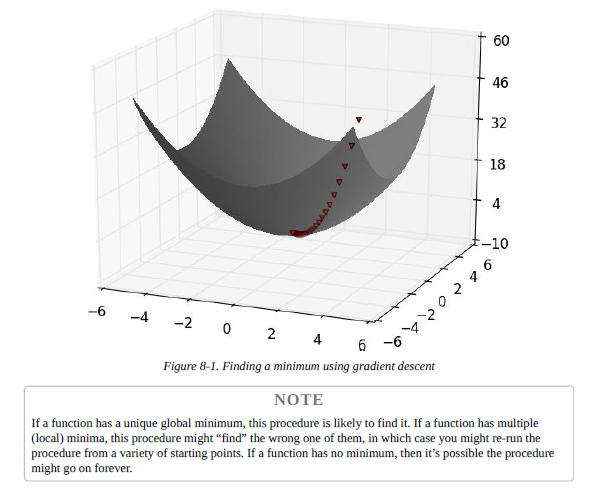

### Estimating the Gradient

If f is a function of one variable, its derivative at a point x measures how f(x) changes
when we make a very small change to x. It is defined as the limit of the difference
quotients:
```python
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h
```
as h approaches zero.

(Many a would-be calculus student has been stymied by the mathematical definition of
limit. Here we’ll cheat and simply say that it means what you think it means.)

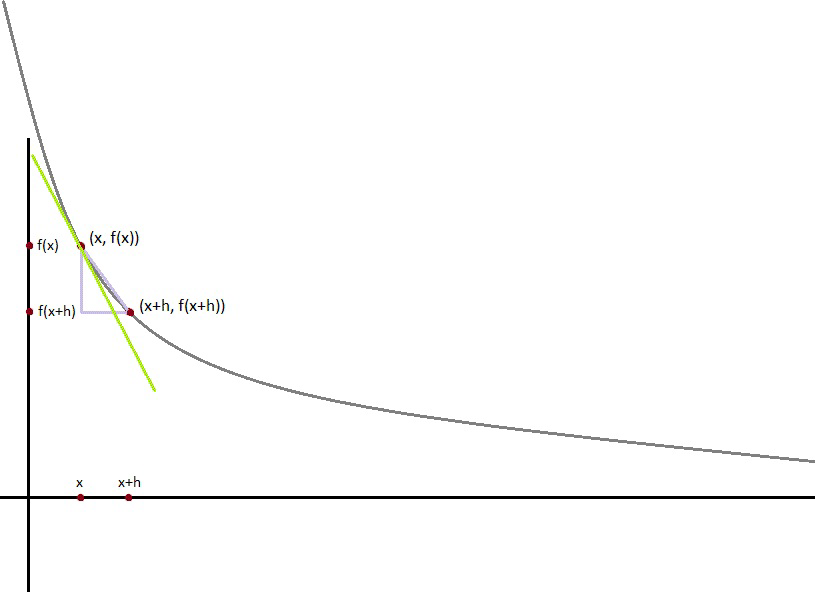

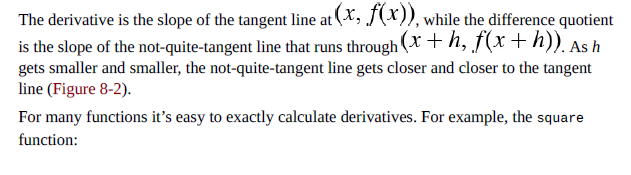



In [2]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def square(x):
    return x*x

def derivative(x):
    return 2*x
    

which you can check — if you are so inclined — by explicitly computing the difference
quotient and taking the limit.
What if you couldn’t (or didn’t want to) find the gradient? Although we can’t take limits
in Python, we can estimate derivatives by evaluating the difference quotient for a very
small e. Figure 8-3 shows the results of one such estimation:

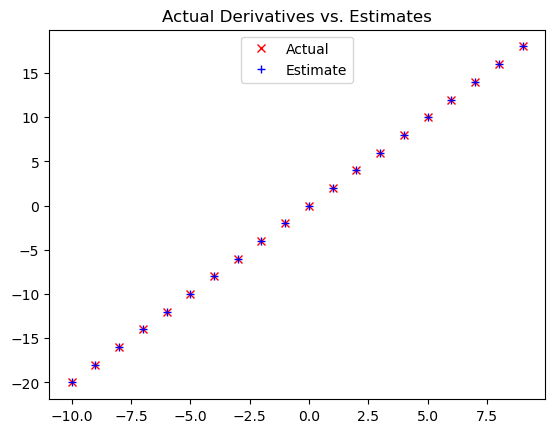

In [7]:
derivative_estimate = partial(difference_quotient, square, h=0.00001)

# Define the range for x
x = range(-10, 10)

# Compute the actual derivatives and estimates
actual_derivatives = list(map(derivative, x))
estimated_derivatives = list(map(derivative_estimate, x))

# Plot the results
plt.title("Actual Derivatives vs. Estimates")
plt.plot(x, actual_derivatives, 'rx', label='Actual')  # red x
plt.plot(x, estimated_derivatives, 'b+', label='Estimate')  # blue +
plt.legend(loc=9)
plt.show()

When f is a function of many variables, it has multiple partial derivatives, each indicating
how f changes when we make small changes in just one of the input variables.
We calculate its ith partial derivative by treating it as a function of just its ith variable,
holding the other variables fixed:

In [9]:
def partial_difference_quotient(f, v, i, h):
    """compute the ith partial difference quotient of f at v"""
    w = [v_j + (h if j == i else 0) # add h to just the ith element of v
    for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h

In [10]:
def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
    for i, _ in enumerate(v)]

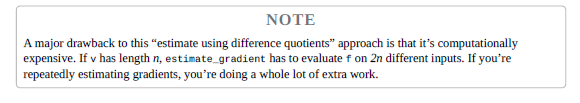

### Using the Gradient
It’s easy to see that the sum_of_squares function is smallest when its input v is a vector of
zeroes. But imagine we didn’t know that. Let’s use gradients to find the minimum among
all three-dimensional vectors. We’ll just pick a random starting point and then take tiny
steps in the opposite direction of the gradient until we reach a point where the gradient is
very small:

In [15]:
import math
def dot_prod(v,w):
    return sum(v_i*w_i for v_i ,w_i in zip(v,w))
def vector_subtract(v,w):
    return [ v_i-w_i for v_i , w_i in zip(v,w)]
def vector_sum_squared(v):
    return dot_prod(v,v)
def squared_distance(v,w):
    """(v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return vector_sum_squared(vector_subtract(v,w))
def distance(v,w):
    return math.sqrt(squared_distance(v,w))

In [17]:
import random

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]
# pick a random starting point
v = [random.randint(-10,10) for i in range(3)]
tolerance = 0.0000001
while True:
    gradient = sum_of_squares_gradient(v) # compute the gradient at v
    next_v = step(v, gradient, -0.01) # take a negative gradient step
    if distance(next_v, v) < tolerance: # stop if we're converging
        print(v)
        break
    v = next_v # continue if we're not
#notice how we end up to a close value to zero the smaller the tolerance the accurate the resuls

[2.121291321259911e-06, 4.242582642519822e-06, 1.4141942141732736e-06]


### Choosing the Right Step Size
Although the rationale for moving against the gradient is clear, how far to move is not.
Indeed, choosing the right step size is more of an art than a science. Popular options
include:
- Using a fixed step size
- Gradually shrinking the step size over time
- At each step, choosing the step size that minimizes the value of the objective function

The last sounds optimal but is, in practice, a costly computation. We can approximate it by
trying a variety of step sizes and choosing the one that results in the smallest value of the
objective function:

In [18]:
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

It is possible that certain step sizes will result in invalid inputs for our function. So we’ll
need to create a “safe apply” function that returns infinity (which should never be the
minimum of anything) for invalid inputs:

In [19]:
def safe(f):
    """return a new function that's the same as f,
    except that it outputs infinity whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf') # this means "infinity" in Python
    return safe_f

### Putting It All Together

In the general case, we have some `target_fn` that we want to minimize, and we also have
its `gradient_fn`. For example, the `target_fn` could represent the errors in a model as a
function of its parameters, and we might want to find the parameters that make the errors
as small as possible.

Furthermore, let’s say we have (somehow) chosen a starting value for the parameters
`theta_0`. Then we can implement gradient descent as:

In [22]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0 # set theta to initial value
    target_fn = safe(target_fn) # safe version of target_fn
    value = target_fn(theta) # value we're minimizing
    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

We called it minimize_batch because, for each gradient step, it looks at the entire data set
(because target_fn returns the error on the whole data set).

In the next section, we’ll see an alternative approach that only looks at one data point at a time.
Sometimes we’ll instead want to maximize a function, which we can do by minimizing its
negative (which has a corresponding negative gradient):

In [24]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)
def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn), negate_all(gradient_fn),theta_0,tolerance)

### Stochastic Gradient Descent
As we mentioned before, often we’ll be using gradient descent to choose the parameters of
a model in a way that minimizes some notion of error. Using the previous batch approach,
each gradient step requires us to make a prediction and compute the gradient for the whole
data set, which makes each step take a long time.

Now, usually these error functions are additive, which means that the predictive error on
the whole data set is simply the sum of the predictive errors for each data point.
When this is the case, we can instead apply a technique called stochastic gradient descent,
which computes the gradient (and takes a step) for only one point at a time. It cycles over
our data repeatedly until it reaches a stopping point.

During each cycle, we’ll want to iterate through our data in a random order:


In [25]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)] # create a list of indexes
    random.shuffle(indexes) # shuffle them
    for i in indexes: # return the data in that order
        yield data[i]

And we’ll want to take a gradient step for each data point. This approach leaves the
possibility that we might circle around near a minimum forever, so whenever we stop
getting improvements we’ll decrease the step size and eventually quit

In [26]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x, y)
    theta = theta_0 # initial guess
    alpha = alpha_0 # initial step size
    min_theta, min_value = None, float("inf") # the minimum so far
    iterations_with_no_improvement = 0
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )
        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    return min_theta

The stochastic version will typically be a lot faster than the batch version. Of course, we’ll
want a version that maximizes as well:

In [27]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
    negate_all(gradient_fn),
    x, y, theta_0, alpha_0)

### For Further Exploration
Keep reading! We’ll be using gradient descent to solve problems throughout the rest of
the book.
- At this point, you’re undoubtedly sick of me recommending that you read textbooks. If
  it’s any consolation, Active Calculus seems nicer than the calculus textbooks I learned
  from.
- scikit-learn has a Stochastic Gradient Descent module that is not as general as ours in
  some ways and more general in other ways. 

Really, though, in most real-world situations you’ll be using libraries in which the optimization is already taken care of
behind the scenes, and you won’t have to worry about it yourself (other than when it
doesn’t work correctly, which one day, inevitably, it won’t